## Financial Institution Fraud Detection Analysis

#### Author: Andrew Tran

## Blog Post Inspiration and Objectives

In this blog post, ...

## Data Preprocessing - Cleaning and Analytics

In [1]:
# Imported needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
from sklearn.model_selection import train_test_split
plt.style.use("fivethirtyeight")

In [2]:
# Reading and displaying the initial dataset
df = pd.read_csv("datasets/bs140513_032310.csv")
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0


In [3]:
# Determining the shape of the initial dataset
df.shape

(594643, 10)

In [4]:
# Getting a sample of the initial dataset through the seeing the first 10 entries
# completely in the dataset
df.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
5,0,'C1315400589','3','F','28007','M348934600','28007','es_transportation',25.81,0
6,0,'C765155274','1','F','28007','M348934600','28007','es_transportation',9.10,0
7,0,'C202531238','4','F','28007','M348934600','28007','es_transportation',21.17,0
8,0,'C105845174','3','M','28007','M348934600','28007','es_transportation',32.40,0
9,0,'C39858251','5','F','28007','M348934600','28007','es_transportation',35.40,0


In [5]:
# Figuring out all of the columns (and their names) available for me to use in 
# the dataset
df.columns

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')

In [6]:
# Getting basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [7]:
# Figuring out the number of duplicated elements in the dataset (could be 
# problematic if not resolved)
df.duplicated().sum()

0

In [8]:
# Renaming the columns to be more readable 
df = df.rename(columns={"zipcodeOri": "ZipCodeOrig", "step": "TimeStep"})

cols_rename_dict = {}
for col in df.columns:
    cols_rename_dict.update({col: str(col[0].upper() + col[1:])})

df = df.rename(columns=cols_rename_dict)
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0


In [9]:
# Figuring out the number of 'null'/'NaN' elements in the dataset (i.e. if NaN 
# filling is needed or not)
print(df.isnull().sum())
(df.isnull().sum() / df.shape[0]) * 100

TimeStep       0
Customer       0
Age            0
Gender         0
ZipCodeOrig    0
Merchant       0
ZipMerchant    0
Category       0
Amount         0
Fraud          0
dtype: int64


TimeStep       0.0
Customer       0.0
Age            0.0
Gender         0.0
ZipCodeOrig    0.0
Merchant       0.0
ZipMerchant    0.0
Category       0.0
Amount         0.0
Fraud          0.0
dtype: float64

In [10]:
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0


In [11]:
# Remove the single quotation characters around the following columns' entries
single_quotation_cols: [str] = ["Customer", "Age", "Gender", "ZipCodeOrig", "Merchant", "ZipMerchant", "Category"]

for col in single_quotation_cols:
    df[col] = df[col].str.strip("'")

df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,28007,M1823072687,28007,es_transportation,20.53,0
594639,179,C650108285,4,F,28007,M1823072687,28007,es_transportation,50.73,0
594640,179,C123623130,2,F,28007,M349281107,28007,es_fashion,22.44,0
594641,179,C1499363341,5,M,28007,M1823072687,28007,es_transportation,14.46,0


In [12]:
df["Age"] = df["Age"].map(lambda entry: entry if entry != "U" else "-1")
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,28007,M1823072687,28007,es_transportation,20.53,0
594639,179,C650108285,4,F,28007,M1823072687,28007,es_transportation,50.73,0
594640,179,C123623130,2,F,28007,M349281107,28007,es_fashion,22.44,0
594641,179,C1499363341,5,M,28007,M1823072687,28007,es_transportation,14.46,0


In [13]:
df["Category"].value_counts()

Category
es_transportation        505119
es_food                   26254
es_health                 16133
es_wellnessandbeauty      15086
es_fashion                 6454
es_barsandrestaurants      6373
es_hyper                   6098
es_sportsandtoys           4002
es_tech                    2370
es_home                    1986
es_hotelservices           1744
es_otherservices            912
es_contents                 885
es_travel                   728
es_leisure                  499
Name: count, dtype: int64

In [14]:
df["Category"] = df["Category"].map(lambda entry: entry.replace("es_", ""))

df["Category"].replace({"barsandrestaurants": "bars_and_restaurants", 
    "hotelservices": "hotel_services", "otherservices": "other_services", 
    "sportsandtoys": "sports_and_toys", "wellnessandbeauty": "wellness_and_beauty"}, inplace=True)

# Fix the capitalization on the entries in the "Category" column for readability
def capitalize_first_letter(entry: str):
    word_entries = entry.split("_")
    word_entries = [(word[0].upper() + word[1:]) for word in word_entries]
    return "_".join(word_entries)

df["Category"] = df["Category"].apply(capitalize_first_letter)
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
0,0,C1093826151,4,M,28007,M348934600,28007,Transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,Transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,Transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,Transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,Transportation,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,28007,M1823072687,28007,Transportation,20.53,0
594639,179,C650108285,4,F,28007,M1823072687,28007,Transportation,50.73,0
594640,179,C123623130,2,F,28007,M349281107,28007,Fashion,22.44,0
594641,179,C1499363341,5,M,28007,M1823072687,28007,Transportation,14.46,0


In [15]:
df["Category"].value_counts()

Category
Transportation          505119
Food                     26254
Health                   16133
Wellness_And_Beauty      15086
Fashion                   6454
Bars_And_Restaurants      6373
Hyper                     6098
Sports_And_Toys           4002
Tech                      2370
Home                      1986
Hotel_Services            1744
Other_Services             912
Contents                   885
Travel                     728
Leisure                    499
Name: count, dtype: int64

In [16]:
df["Gender"] = df["Gender"].map({"M": "Male", "F": "Female", "E": "Enterprise", "U": "Unknown"})
df

,TimeStep,Customer,Age,Gender,ZipCodeOrig,Merchant,ZipMerchant,Category,Amount,Fraud
0,0,C1093826151,4,Male,28007,M348934600,28007,Transportation,4.55,0
1,0,C352968107,2,Male,28007,M348934600,28007,Transportation,39.68,0
2,0,C2054744914,4,Female,28007,M1823072687,28007,Transportation,26.89,0
3,0,C1760612790,3,Male,28007,M348934600,28007,Transportation,17.25,0
4,0,C757503768,5,Male,28007,M348934600,28007,Transportation,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,Female,28007,M1823072687,28007,Transportation,20.53,0
594639,179,C650108285,4,Female,28007,M1823072687,28007,Transportation,50.73,0
594640,179,C123623130,2,Female,28007,M349281107,28007,Fashion,22.44,0
594641,179,C1499363341,5,Male,28007,M1823072687,28007,Transportation,14.46,0


In [17]:
df["Age"] = df["Age"].astype("int64")
df["ZipCodeOrig"] = df["ZipCodeOrig"].astype("int64")
df["ZipMerchant"] = df["ZipMerchant"].astype("int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TimeStep     594643 non-null  int64  
 1   Customer     594643 non-null  object 
 2   Age          594643 non-null  int64  
 3   Gender       594643 non-null  object 
 4   ZipCodeOrig  594643 non-null  int64  
 5   Merchant     594643 non-null  object 
 6   ZipMerchant  594643 non-null  int64  
 7   Category     594643 non-null  object 
 8   Amount       594643 non-null  float64
 9   Fraud        594643 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 45.4+ MB


C:\Users\andre\AppData\Local\Temp\ipykernel_21372\4039904578.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(df["Category"].unique()),


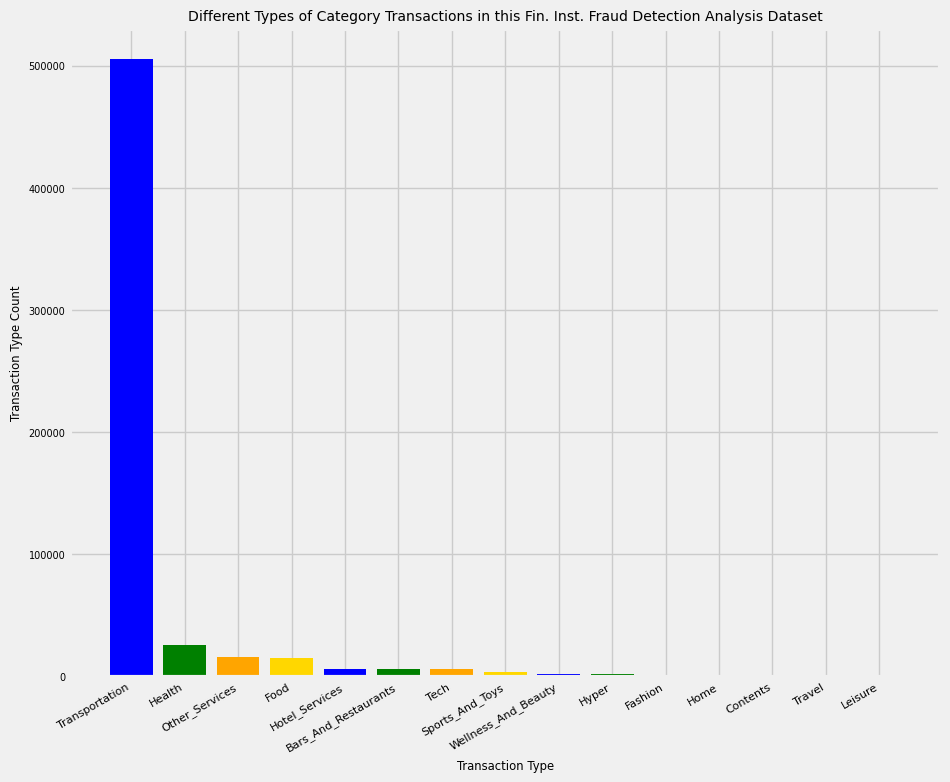

Category
Transportation          505119
Food                     26254
Health                   16133
Wellness_And_Beauty      15086
Fashion                   6454
Bars_And_Restaurants      6373
Hyper                     6098
Sports_And_Toys           4002
Tech                      2370
Home                      1986
Hotel_Services            1744
Other_Services             912
Contents                   885
Travel                     728
Leisure                    499
Name: count, dtype: int64

In [18]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
plt.bar(x=df["Category"].unique(), height=df["Category"].value_counts(), color=["blue", "green", "orange", "gold"])
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Type Count")
plt.title("Different Types of Category Transactions in this Fin. Inst. Fraud Detection Analysis Dataset")
ax = plt.subplot()
ax.set_xticklabels(list(df["Category"].unique()),
                   rotation=30,
                   fontsize="8",
                   horizontalalignment="right")
plt.show()
df["Category"].value_counts()

C:\Users\andre\AppData\Local\Temp\ipykernel_21372\3101644515.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(df["Gender"].unique()),


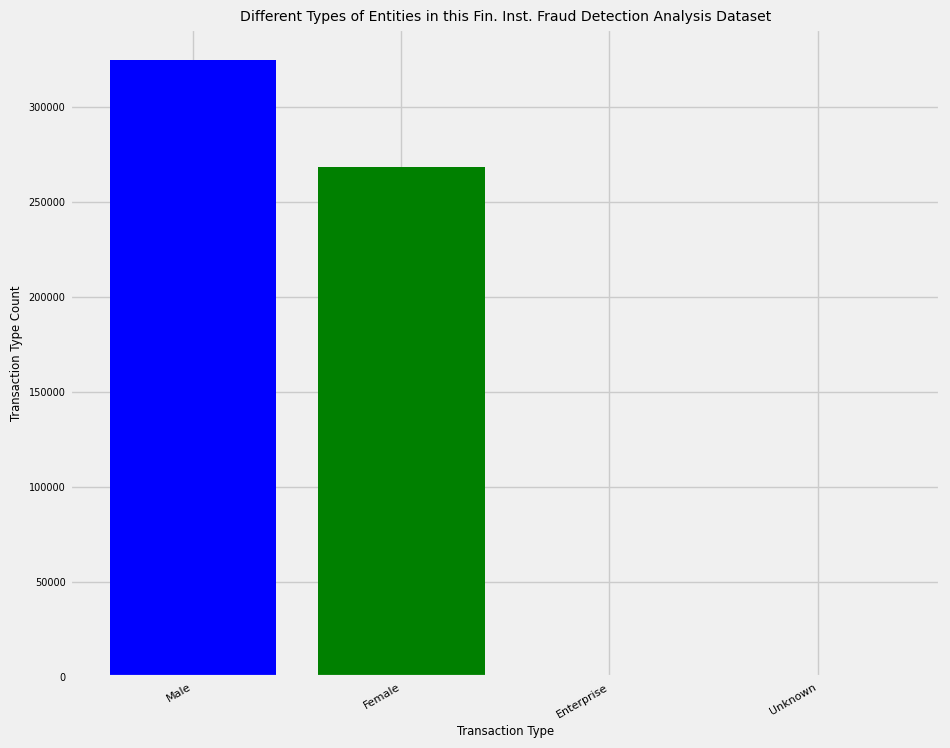

Gender
Female        324565
Male          268385
Enterprise      1178
Unknown          515
Name: count, dtype: int64

In [19]:
plt.figure(figsize=(10, 8))
plt.rcParams["font.size"] = 7
plt.bar(x=df["Gender"].unique(), height=df["Gender"].value_counts(), color=["blue", "green", "orange", "gold"])
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Type Count")
plt.title("Different Types of Entities in this Fin. Inst. Fraud Detection Analysis Dataset")
ax = plt.subplot()
ax.set_xticklabels(list(df["Gender"].unique()),
                   rotation=30,
                   fontsize="8",
                   horizontalalignment="right")
plt.show()
df["Gender"].value_counts()

In [20]:
# Set the display precision for floating-point numbers to 3 decimal places
pd.set_option("display.float_format", "{:.2f}".format)
df.loc[:, ["TimeStep", "Amount"]].describe()

,TimeStep,Amount
count,594643.00,594643.00
mean,94.99,37.89
std,51.05,111.40
min,0.00,0.00
25%,52.00,13.74
50%,97.00,26.90
75%,139.00,42.54
max,179.00,8329.96


In [21]:
# Step = Map of unit of time in the real world. 1 step = 1 hour
df["TimeStep"].value_counts()

TimeStep
175    3774
177    3758
152    3746
178    3743
174    3743
       ... 
5      2525
3      2499
2      2462
0      2430
1      2424
Name: count, Length: 180, dtype: int64

<Axes: title={'center': 'Distribution of Time Feature'}, xlabel='TimeStep', ylabel='count'>

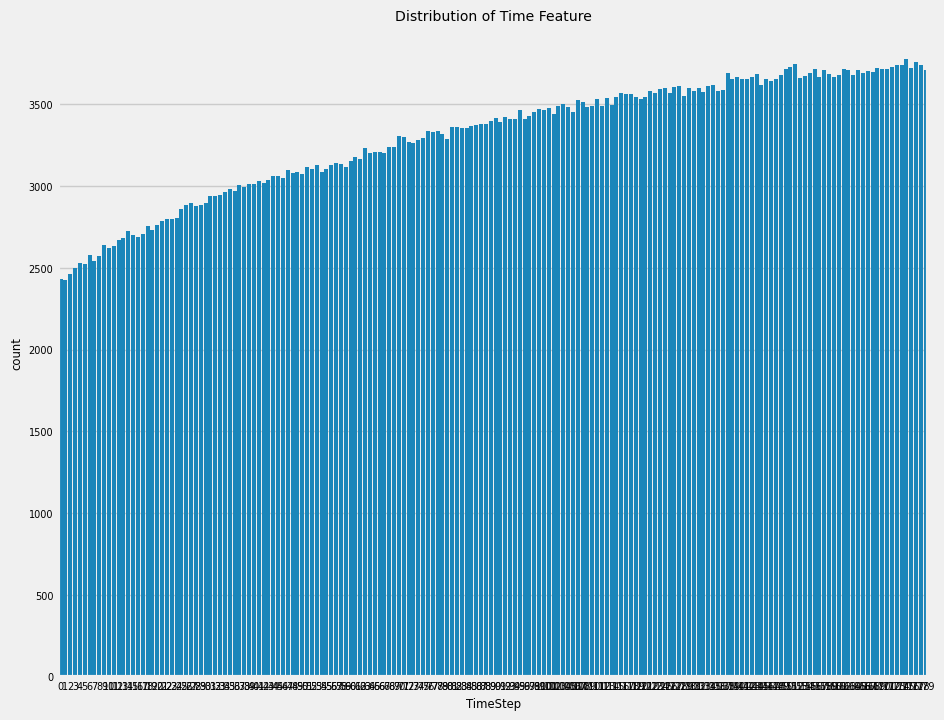

In [22]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.countplot(x="TimeStep", data=df)

In [23]:
df["Amount"].value_counts()

Amount
26.67     146
14.93     146
17.57     145
17.26     143
16.12     143
         ... 
222.85      1
99.86       1
164.50      1
112.54      1
190.31      1
Name: count, Length: 23767, dtype: int64

In [24]:
df.shape

(594643, 10)

In [25]:
df["Amount"].value_counts()

Amount
26.67     146
14.93     146
17.57     145
17.26     143
16.12     143
         ... 
222.85      1
99.86       1
164.50      1
112.54      1
190.31      1
Name: count, Length: 23767, dtype: int64

Note: The number of entries above the filtered amount value of 250 is 5510 (0.93% of total entries).


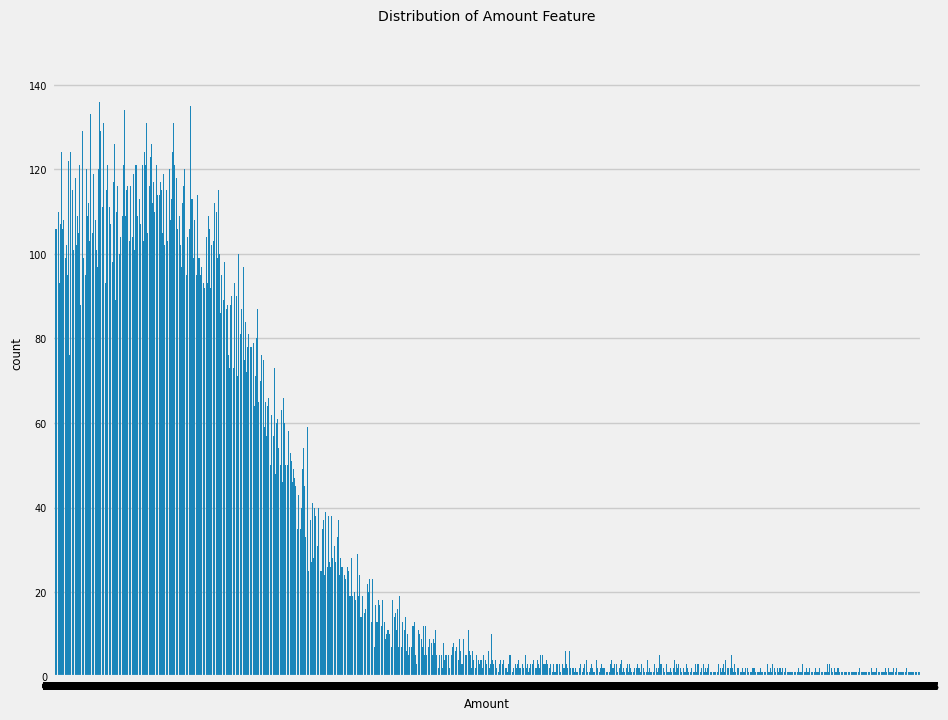

In [26]:
amount_counts = df["Amount"].value_counts()
amount_filter_value: float = 250.00
df_amount_dist_display_sample = df[df["Amount"] <= amount_filter_value]
num_entries_above_amount_filter_value = df[df["Amount"] > amount_filter_value].shape[0]
perc_amount_above_amount_filter_value = (float(num_entries_above_amount_filter_value) / df.shape[0]) * 100
print(f"Note: The number of entries above the filtered amount value of {int(amount_filter_value)} is {num_entries_above_amount_filter_value} \
({perc_amount_above_amount_filter_value:.2f}% of total entries).")
plt.figure(figsize=(10,8))
plt.title('Distribution of Amount Feature')
# interval = 50
# ax = plt.gca()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=interval))
# custom_x_ticks = range(0, int(df_amount_dist_display_sample["Amount"].max()) + 1, 50)
# custom_x_tick_labels = [str(tick) for tick in custom_x_ticks]
# plt.xticks(custom_x_ticks, custom_x_tick_labels)
# fig, ax = plt.subplots()
# x_start, x_end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(x_start, x_end, 50))
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
sns.countplot(x="Amount", data=df_amount_dist_display_sample)
# ax = sns.countplot(x="Amount", data=df_amount_dist_display_sample)
# interval = 50
# ax.set_xticks(range(0, int(df_amount_dist_display_sample["Amount"].max()) + 1, interval))
plt.show()

In [27]:
counts_fraud_col = df["Fraud"].value_counts()
normal_cases, fraud_cases = counts_fraud_col[0], counts_fraud_col[1]
percent_normal = (normal_cases / (normal_cases + fraud_cases)) * 100
percent_fraud = (fraud_cases / (normal_cases + fraud_cases)) * 100
results = f"There were {normal_cases} non-fraudulent transactions ({percent_normal:.3f}%) \
and {fraud_cases} fradulent transactions ({percent_fraud:.3f}%)"
results

'There were 587443 non-fraudulent transactions (98.789%) and 7200 fradulent transactions (1.211%)'

Text(0.5, 0, 'Class: (0 - Non-Fraudulent vs. 1 - Fradulent)')

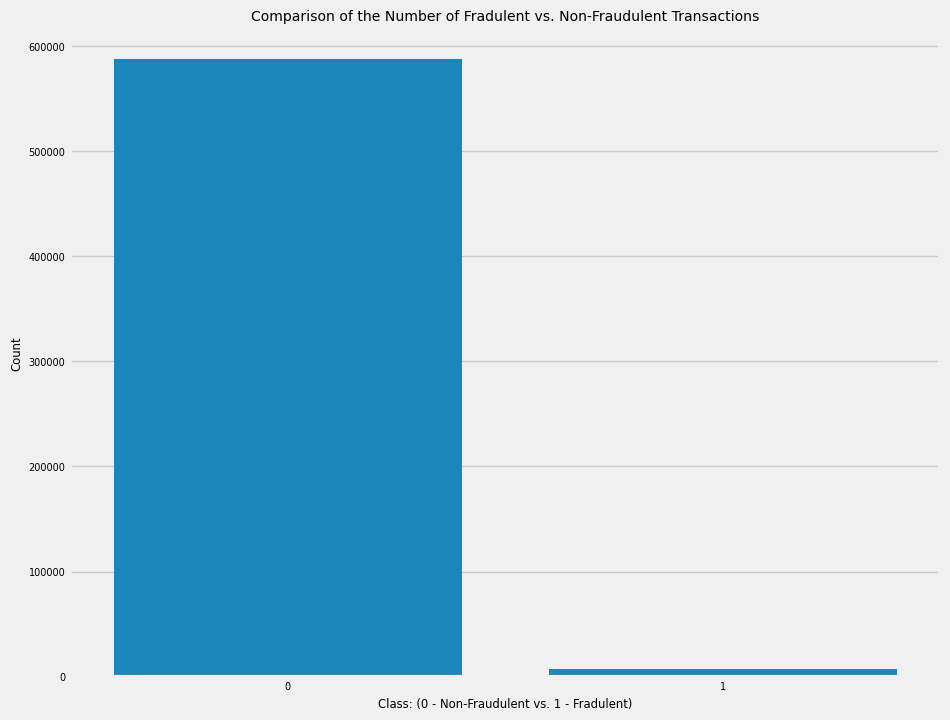

In [28]:
plt.figure(figsize=(10, 8))
sns.barplot(x=counts_fraud_col.index, y=counts_fraud_col)
plt.title("Comparison of the Number of Fradulent vs. Non-Fraudulent Transactions")
plt.ylabel("Count")
# plt.yticks(np.arange(0, max(counts_fraud_col) + 1, 1000))
plt.xlabel("Class: (0 - Non-Fraudulent vs. 1 - Fradulent)")

In [29]:
print("Mean Feature Values per Category:")
df_category_grouping_amount_mean = df.groupby('Category')["Amount"].mean()
df_category_grouping_fraud_mean = df.groupby('Category')["Fraud"].mean()
df_mean = pd.concat([df_category_grouping_amount_mean, df_category_grouping_fraud_mean], keys=["Amount", "Fraud"])
df_mean = pd.DataFrame(index=df["Category"].unique())
df_mean = pd.merge(left=df_mean, right=df_category_grouping_amount_mean, how="inner", left_on=df_mean.index, right_on=df_category_grouping_amount_mean.index)
df_mean.rename(columns={"key_0": "Category"}, inplace=True)
df_mean.set_index(keys="Category", drop=True, inplace=True)
df_mean = pd.merge(left=df_mean, right=df_category_grouping_fraud_mean, how="inner", left_on=df_mean.index, right_on=df_category_grouping_fraud_mean.index)
df_mean.rename(columns={"key_0": "Category"}, inplace=True)
df_mean.set_index(keys="Category", drop=True, inplace=True)
df_mean

Mean Feature Values per Category:


,Amount,Fraud
Category,,
Transportation,26.96,0.00
Health,135.62,0.11
Other_Services,135.88,0.25
Food,37.07,0.00
Hotel_Services,205.61,0.31
Bars_And_Restaurants,43.46,0.02
Tech,120.95,0.07
Sports_And_Toys,215.72,0.50
Wellness_And_Beauty,65.51,0.05


In [30]:
df_non_fraud = df[df["Fraud"] == 0]
df_fraud = df[df["Fraud"] == 1]

pd.concat([df_fraud.groupby("Category")["Amount"].mean(), df_non_fraud.groupby("Category")["Amount"].mean(), \
    df.groupby("Category")["Fraud"].mean() * 100], keys=["Fraudulent", "Non-Fradulent", "Percentage (%)"], axis=1, \
    sort=False).sort_values(by=["Non-Fradulent"])

,Fraudulent,Non-Fradulent,Percentage (%)
Category,,,
Transportation,NaN,26.96,0.00
Food,NaN,37.07,0.00
Hyper,169.26,40.04,4.59
Bars_And_Restaurants,164.09,41.15,1.88
Contents,NaN,44.55,0.00
Wellness_And_Beauty,229.42,57.32,4.76
Fashion,247.01,62.35,1.80
Leisure,300.29,73.23,94.99
Other_Services,316.47,75.69,25.00


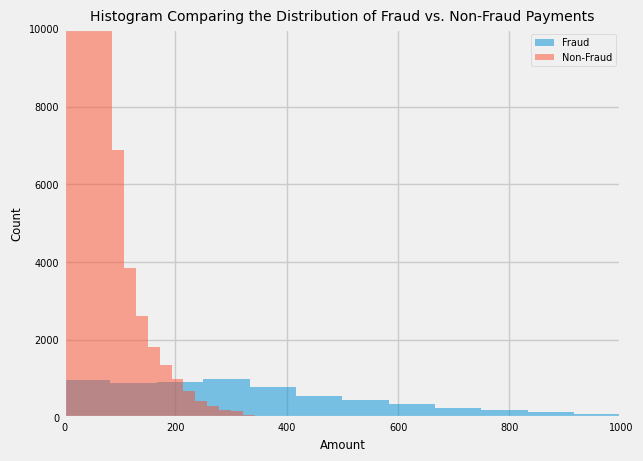

In [31]:
# Plot histograms of the amounts in fraud and non-fraud data
hist_bins: int = 100
plt.hist(df_fraud["Amount"], alpha=0.5, label="Fraud", bins=hist_bins)
plt.hist(df_non_fraud["Amount"], alpha=0.5, label="Non-Fraud", bins=hist_bins)
plt.title("Histogram Comparing the Distribution of Fraud vs. Non-Fraud Payments")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.xlim(0, 1000)
plt.ylim(0, 10000)
plt.legend()
plt.show()

In [32]:
df.drop(labels=["Customer", "ZipCodeOrig", "Merchant", "ZipMerchant"], axis=1, inplace=True)
df

,TimeStep,Age,Gender,Category,Amount,Fraud
0,0,4,Male,Transportation,4.55,0
1,0,2,Male,Transportation,39.68,0
2,0,4,Female,Transportation,26.89,0
3,0,3,Male,Transportation,17.25,0
4,0,5,Male,Transportation,35.72,0
...,...,...,...,...,...,...
594638,179,3,Female,Transportation,20.53,0
594639,179,4,Female,Transportation,50.73,0
594640,179,2,Female,Fashion,22.44,0
594641,179,5,Male,Transportation,14.46,0


In [33]:
df["Amount"] = df["Amount"].round(2)
df

,TimeStep,Age,Gender,Category,Amount,Fraud
0,0,4,Male,Transportation,4.55,0
1,0,2,Male,Transportation,39.68,0
2,0,4,Female,Transportation,26.89,0
3,0,3,Male,Transportation,17.25,0
4,0,5,Male,Transportation,35.72,0
...,...,...,...,...,...,...
594638,179,3,Female,Transportation,20.53,0
594639,179,4,Female,Transportation,50.73,0
594640,179,2,Female,Fashion,22.44,0
594641,179,5,Male,Transportation,14.46,0


In [34]:
df["Category"].value_counts()

Category
Transportation          505119
Food                     26254
Health                   16133
Wellness_And_Beauty      15086
Fashion                   6454
Bars_And_Restaurants      6373
Hyper                     6098
Sports_And_Toys           4002
Tech                      2370
Home                      1986
Hotel_Services            1744
Other_Services             912
Contents                   885
Travel                     728
Leisure                    499
Name: count, dtype: int64

In [35]:
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1, "Enterprise": 2, "Unknown": 3}).astype("int64")
df["Category"] = df["Category"].map({"Transportation": 0, "Food": 1, "Health": 2, "Wellness_And_Beauty": 3,
                                    "Fashion": 4, "Bars_And_Restaurants": 5, "Hyper": 6, "Sports_And_Toys": 7,
                                    "Tech": 8, "Home": 9, "Hotel_Services": 10, "Other_Services": 11, 
                                    "Contents": 12, "Travel": 13, "Leisure": 14}).astype("int64")
display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   TimeStep  594643 non-null  int64  
 1   Age       594643 non-null  int64  
 2   Gender    594643 non-null  int64  
 3   Category  594643 non-null  int64  
 4   Amount    594643 non-null  float64
 5   Fraud     594643 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 27.2 MB


None

,TimeStep,Age,Gender,Category,Amount,Fraud
0,0,4,0,0,4.55,0
1,0,2,0,0,39.68,0
2,0,4,1,0,26.89,0
3,0,3,0,0,17.25,0
4,0,5,0,0,35.72,0
...,...,...,...,...,...,...
594638,179,3,1,0,20.53,0
594639,179,4,1,0,50.73,0
594640,179,2,1,4,22.44,0
594641,179,5,0,0,14.46,0


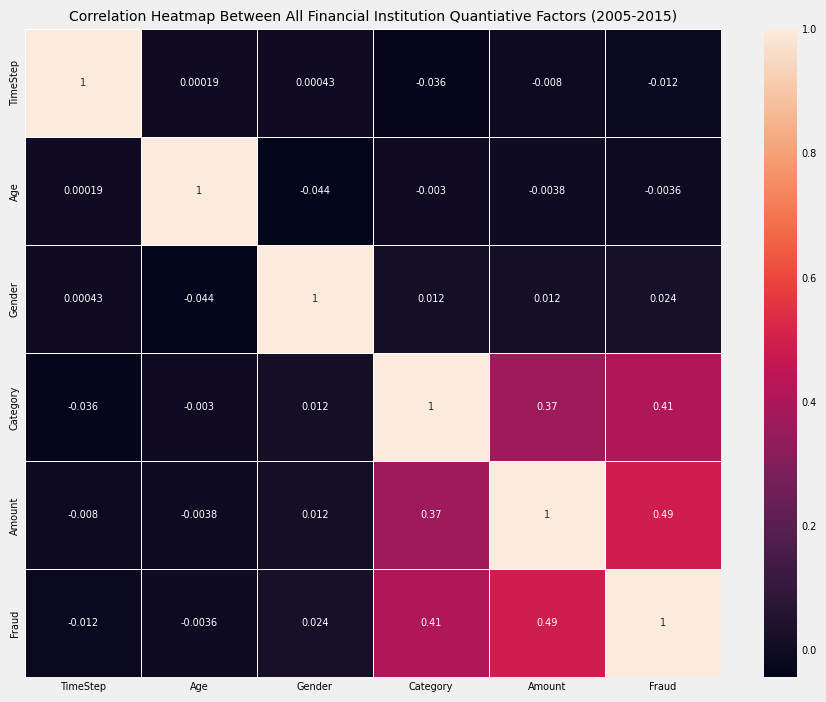

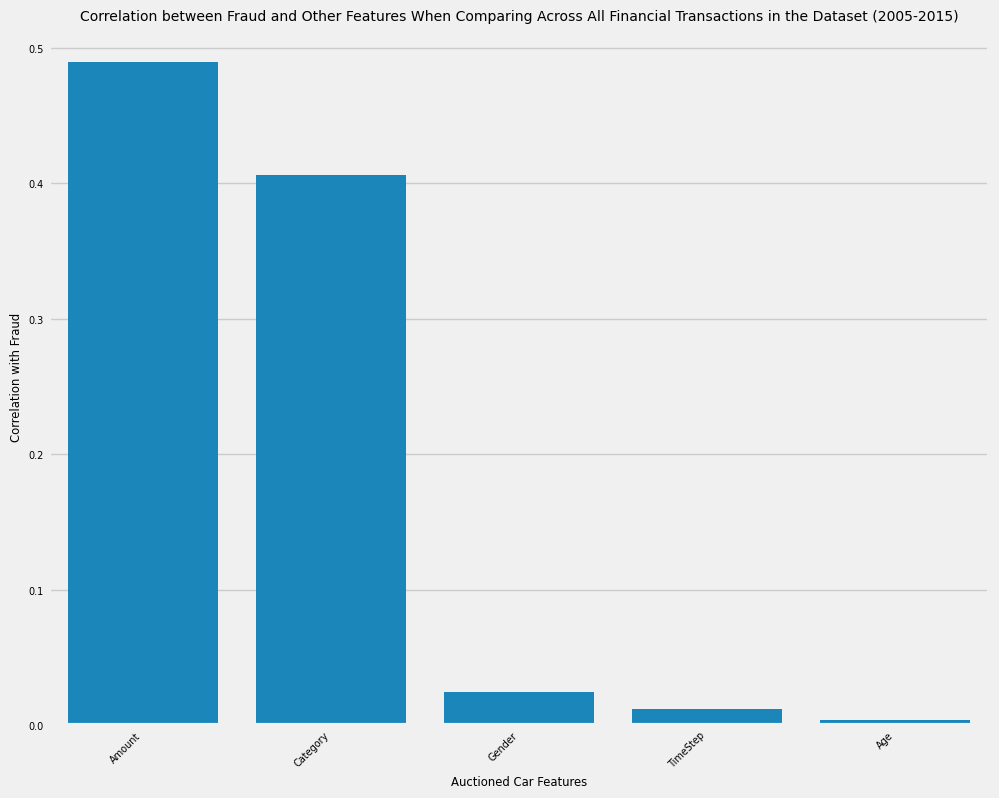

In [36]:
# Correlation heatmap to quantify relationships between auctioning used-car
# attributes
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, linewidths=0.5)
plt.title("Correlation Heatmap Between All Financial Institution Quantiative Factors (2005-2015)")
plt.show()

# Correlation bar graph between ROI and all other auctioning used-car
# attributes
target_corr = df.corr()["Fraud"].abs().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.index[1:], y=target_corr.values[1:])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Auctioned Car Features")
plt.ylabel("Correlation with Fraud")
plt.title("Correlation between Fraud and Other Features When Comparing Across All Financial Transactions in the Dataset (2005-2015)")
plt.tight_layout()
plt.show()

## Machine Learning - Model Training and Evaluation

Great, now we are onto the Machine Learning part of the blog post!

In [38]:
X = df.drop(["Fraud"], axis=1)
y = df["Fraud"]

print("X Shape:", X.shape)
print("Y Shape:", y.shape)

pipeline = Pipeline([
    ("min_max_scaler", MinMaxScaler()),
    ("std_scaler", StandardScaler())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)

X Shape: (594643, 5)
Y Shape: (594643,)


## TO-DO

- Heatmap
- Drop all needed columns
- train_test_split
- Figure out which ML algorithm to use
- Do DBSCAN (as recommended)
- Report classification statistics if needed
- DONE...

Sources:

- Data: https://www.kaggle.com/datasets/ealaxi/paysim1/data (NOT USED)

- Data: https://www.kaggle.com/datasets/ealaxi/banksim1 (USED)

- https://www.kaggle.com/code/mukulkirti/outlier-or-anomalies-detection-and-removal#3.3-DBScane-Anomaly-Detection
